In [5]:
from pytorch_variational_autoencoder import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from tqdm import tnrange

In [6]:
# Data loaders
trainloader = DataLoader(
    MNIST(root=str(Path.home()) + '/Documents/datasets/mnist',train=True,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)
testloader = DataLoader(
    MNIST(root=str(Path.home()) + '/Documents/datasets/mnist',train=False,download=True,transform=transforms.ToTensor()),
    batch_size=128,shuffle=True)

In [7]:
# loading the model
model = VAE()
model.load_state_dict(torch.load('model.pkl'))

In [8]:
# Visualize moving average of losses
def visualize_losses_moving_average(losses,window=50,boundary='valid',ylim=(95,125)):
    mav_losses = np.convolve(losses,np.ones(window)/window,boundary)
    corrected_mav_losses = np.append(np.full(window-1,np.nan),mav_losses)
    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.plot(corrected_mav_losses)
    plt.ylim(ylim)
    plt.show()

In [9]:
def test(model,dataloader):
    running_loss = 0.0
    for images, _ in dataloader:
        x_in = Variable(images)
        x_out, z_mu, z_logvar = model(x_in)
        loss = criterion(x_out,x_in,z_mu,z_logvar)
        running_loss = running_loss + (loss.data[0]*x_in.size(0))
    return running_loss/len(dataloader.dataset)

test_loss = test(model,test_loader)
print(test_loss)

107.35289794921874


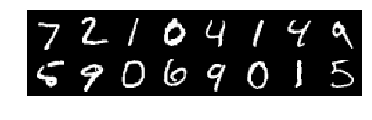

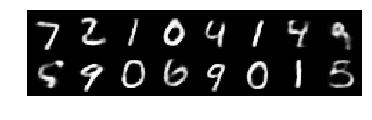

In [10]:
# Visualize VAE input and reconstruction
def visualize_mnist_vae(model,dataloader,num=16):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
        
    images,_ = iter(dataloader).next()
    images = images[0:num,:,:]
    x_in = Variable(images)
    x_out,_,_ = model(x_in)
    x_out = x_out.data
    imshow(make_image_grid(images))
    imshow(make_image_grid(x_out))

visualize_mnist_vae(model,test_loader)